In [1]:
#%%capture
#!pip install transformers
#!pip install pytorch-lightning

In [2]:
import os
import matplotlib.pyplot as plt

In [3]:
train_path = "/Users/maxschaffelder/Desktop/Thesis/Playground/Experimental data/train.csv"
val_path = "/Users/maxschaffelder/Desktop/Thesis/Playground/Experimental data/val.csv"
test_path = "/Users/maxschaffelder/Desktop/Thesis/Playground/Experimental data/test.csv"


In [4]:
import pandas as pd
train_data = pd.read_csv(train_path)

In [5]:
train_data.head()

,_unit_id,_trusted_judgments,comment,antagonize,antagonize:confidence,condescending,condescending:confidence,dismissive,dismissive:confidence,generalisation,generalisation:confidence,generalisation_unfair,generalisation_unfair:confidence,healthy,healthy:confidence,hostile,hostile:confidence,sarcastic,sarcastic:confidence
0,2319157561,4,"Three marriages, several bankrupt periods, inh...",0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,0.7578,0,0.7565,0,1.0000
1,1739464982,4,The sense of entitlement among high school 'jo...,0,0.7634,0,0.7634,0,0.7634,0,1.0000,0.0,1.0,1,0.7634,0,0.7634,0,0.7634
2,1739457583,5,So what? He was just stating the obvious.,0,0.8121,0,0.5928,0,0.8043,0,1.0000,0.0,1.0,1,0.6163,0,1.0000,0,1.0000
3,2319156950,40,"If one is a Con, why yes, one would honk. Loud...",0,0.8508,0,0.8867,0,0.9239,0,0.8863,0.0,1.0,1,0.8508,0,0.9641,0,0.8868
4,2327196492,3,Ooohhh... It's Wendy Whiner... making sure to ...,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,1.0000,0,1.0000,0,1.0000


<AxesSubplot:>

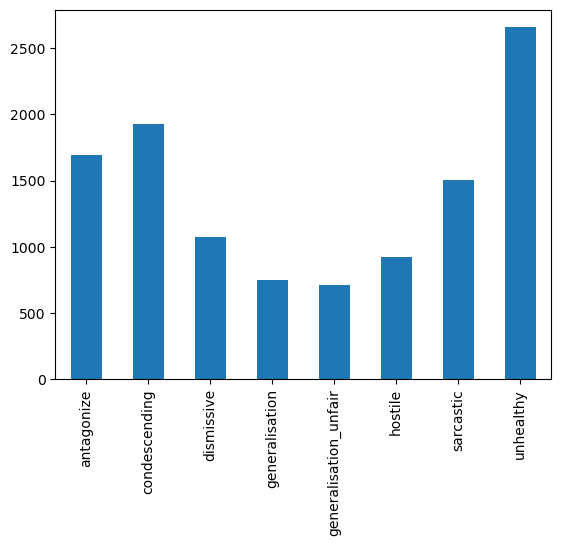

In [6]:
import numpy as np
train_data["unhealthy"] = np.where(train_data["healthy"] == 1, 0, 1)

attributes = ["antagonize", "condescending", "dismissive", "generalisation",
              "generalisation_unfair", "hostile", "sarcastic", "unhealthy"]


train_data[attributes].sum().plot.bar()

In [7]:
from torch.utils.data import Dataset
import torch

In [8]:
class UCC_Dataset(Dataset):

    def __init__(self, data_path, tokenizer, attributes, max_token_len: int = 128, sample = 5000):
        self.data_path = data_path
        self.tokenizer = tokenizer
        self.attributes = attributes
        self.max_token_len = max_token_len
        self.sample = sample
        self._prepare_data()

    def _prepare_data(self):
        data = pd.read_csv(self.data_path)
        data["unhealthy"] = np.where(data["healthy"] == 1, 0, 1)
        if self.sample is not None:
            unhealthy = data.loc[data[attributes].sum(axis=1) > 0]
            healthy = data.loc[data[attributes].sum(axis=1) == 0]
            self.data = pd.concat([unhealthy, healthy.sample(self.sample, random_state=7)])

        else:
            self.data = data

    def __len__(self):
        return(len(self.data))

    def __getitem__(self, index):
        item = self.data.iloc[index]
        comment = str(item.comment)
        attributes = torch.FloatTensor(item[self.attributes])
        tokens = self.tokenizer.encode_plus(comment, 
                                            add_special_tokens=True, 
                                            return_tensors="pt", 
                                            truncation=True, 
                                            max_length=self.max_token_len,
                                            padding="max_length",
                                            return_attention_mask=True)
    
        return {"input_ids": tokens.input_ids.flatten(), "attention_mask": tokens.attention_mask.flatten(), "labels": attributes}


In [9]:
from transformers import AutoTokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
ucc_ds = UCC_Dataset(train_path, tokenizer, attributes)
ucc_ds_val = UCC_Dataset(val_path, tokenizer, attributes, sample=None)

In [10]:
ucc_ds.__getitem__(0)

{'input_ids': tensor([    0, 19897, 29846,     4,    38,    64,    75,   679, 46301,    74,
          9802,   132,     9,    39,   308,    95,     7,  1471,   559,   332,
             8,   146,  7064,   356,  1099,     4,   370,   214,   235,     6,
         46301,    16,    10, 34759,     4,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [11]:
len(ucc_ds)

9960

In [12]:
#!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

In [13]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader

In [14]:
class UCC_Data_Module(pl.LightningDataModule):
  
  def __init__(self, train_path, val_path, attributes, batch_size: int = 16, 
               max_token_length: int = 128, model_name = "roberta-base"):
    super().__init__()
    self.train_path = train_path
    self.val_path = val_path
    self.attributes = attributes
    self.batch_size = batch_size
    self.max_token_length = max_token_length
    self.model_name = model_name
    self.tokenizer =  AutoTokenizer.from_pretrained(model_name)


  def setup(self, stage = None):
    if stage in (None, "fit"):
      self.train_dataset = UCC_Dataset(self.train_path, self.tokenizer, self.attributes)
      self.val_dataset = UCC_Dataset(self.val_path, self.tokenizer, self.attributes, sample=None)

    if stage == "predict":
      self.val_dataset = UCC_Dataset(self.val_path, self.tokenizer, self.attributes, sample=None)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=4, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False)
  
  def predict_dataloader(self):
    return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False)



In [15]:
ucc_data_module = UCC_Data_Module(train_path, val_path, attributes)

In [16]:
ucc_data_module.setup()

In [17]:
d1 = ucc_data_module.train_dataloader()

In [18]:
len(d1)

623

### Model

In [19]:
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F 


In [20]:
class UCC_Classifier(pl.LightningModule):

  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config["model_name"], return_dict = True)
    self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = nn.Linear(self.pretrained_model.config.hidden_size, self.config["n_labels"])
    torch.nn.init.xavier_uniform_(self.hidden.weight)
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.loss_func = nn.BCEWithLogitsLoss(reduction="mean")
    self.dropout = nn.Dropout()

  def forward(self, input_ids, attention_mask, labels=None):
    # roberta model
    output = self.pretrained_model(input_ids = input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # neural network classification layers
    pooled_output = self.hidden(pooled_output)
    pooled_output = self.dropout(pooled_output)
    pooled_output = F.relu(pooled_output)
    logits = self.classifier(pooled_output)
    # calculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config["n_labels"]), labels.view(-1, self.config["n_labels"]))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log("train loss", loss, prog_bar = True, logger = True)
    return {"loss":loss, "predictions":logits, "labels": batch["labels"]}

  def validation_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log("validation loss", loss, prog_bar = True, logger = True)
    return {"val_loss":loss, "predictions":logits, "labels": batch["labels"]}

  def predict_step(self, batch, batch_index):
    _, logits = self(**batch)
    return logits

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config["lr"], weight_decay=self.config["w_decay"])
    total_steps = self.config["train_size"] / self.config["bs"]
    warmup_steps = math.floor(total_steps * self.config["warmup"])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer], [scheduler]


In [21]:
config = {
    "model_name": "distilroberta-base",
    "n_labels": len(attributes),
    "bs": 128,
    "lr": 1.5e-6,
    "warmup": 0.2,
    "train_size": len(ucc_data_module.train_dataloader()),
    "w_decay": 0.001,
    "n_epochs": 100
}

model = UCC_Classifier(config)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
idx = 0
input_ids = ucc_ds.__getitem__(idx)["input_ids"]
am = ucc_ds.__getitem__(idx)["attention_mask"]
labels = ucc_ds.__getitem__(idx)["labels"]
loss, output = model(input_ids.unsqueeze(dim=0), am.unsqueeze(dim=0), labels.unsqueeze(dim=0))


In [23]:
loss, output

(tensor(0.7897, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor([[-0.3390,  0.1106,  0.4760,  0.8303,  0.6682, -0.1739, -0.2087,  0.2138]],
        grad_fn=<AddmmBackward0>))

In [24]:
# datamodule

ucc_data_module = UCC_Data_Module(train_path, val_path, attributes, batch_size = config["bs"])
ucc_data_module.setup()

# model
model = UCC_Classifier(config)

# train
trainer = pl.Trainer(max_epochs=config["n_epochs"], num_sanity_val_steps=50)
trainer.fit(model, ucc_data_module)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/maxschaffelder/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Us

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/maxschaffelder/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/maxschaffelder/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'UCC_Dataset' on <module '__main__' (built-in)>
/Users/maxschaffelder/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
